In [1]:
## testing printing output from console
import subprocess

cmd = [ 'echo', '"Welcome to my PySpark analysis of the StackOverflow dataset"' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

b'"Welcome to my PySpark analysis of the StackOverflow dataset"\n'


# Load Libraries

In [2]:
import gc #garbage collection
import time
import numpy as np
import pandas as pd
from datetime import datetime

# Load PySpark

In [3]:
%run -i '1-load-pyspark.py'

The Spark UI, version 2.4.3, is available at: http://192.168.0.26:4040/ and the defaultParallelism is 4


# Load easyFunctions and Transformers

In [4]:
## easy functions
%run -i 'load_parquet_data.py'
%run -i 'convert_stackov_csv_to_pyarrow_parquet.py'
%run -i 'export_parquet_data.py'
%run -i 'count_total_questions.py'
%run -i 'show_save_results.py'
%run -i 'show_spark_df.py'
%run -i 'show_date_range.py'
%run -i 'trim_betw_dates.py'

## pipeline transformers
%run -i 'nltkWordPunctTokeniser.py'
%run -i 'nltkSenteniser.py'

# Choose Datasets

In [5]:
## these are the forum labels that will appear in graphs/tables etc.
data_array = [
    #'Mar-09',
    #'Apr-09',
    
    'May-09',
    'Jun-09',
    'Jul-09',
    'Aug-09',
    'Sep-09',
    
    #'Oct-09', #breaks here
    #'Nov-09',
    #'Dec-09'
]

# Download XML Data

In [6]:
## call download script - EDIT to feed in user data_array
#!bash 0-dataset-download.sh

# Convert to Parquet

In [7]:
%%time
print(datetime.now().time())

## convert stackoverflow .json files to .parquet
#for i in data_array:
#    s = i.lower()
#    convert_stackov_csv_to_pyarrow_parquet(strDirect=f'initial-data/{s}.stackexchange.com/')

08:49:25.969618
CPU times: user 477 µs, sys: 232 µs, total: 709 µs
Wall time: 725 µs


In [8]:
## loop through data_array to convert to other fora to .parquet
#for i in data_array:
#    s = i.lower()
#    !python convert-xml-to-parquet.py "$s"

# Load Initial or Clean Data

In [9]:
%%time
print(datetime.now().time())
datasets = load_parquet_data(dataArray=data_array, kind='clean', printSchema=False) #, gcpath='gs://bucket-brad-project/')

08:49:26.272633
CPU times: user 4.49 ms, sys: 2.79 ms, total: 7.28 ms
Wall time: 4.72 s


In [10]:
## count questions before trimming
count_total_questions(dataArray=data_array, datasetDict=datasets)

May-09: 26026
Jun-09: 28555
Jul-09: 32752
Aug-09: 32998
Sep-09: 33268

Total: 153599


# Clean and Trim Data

In [11]:
%%time
print(datetime.now().time())
#%run -i '2-clean-datasets.py'

08:49:34.535022
CPU times: user 178 µs, sys: 55 µs, total: 233 µs
Wall time: 192 µs


In [12]:
## show range of dates for datasets before trimming
show_date_range(dataArray=data_array, datasetDict=datasets)

May-09:
2009-05-01 00:02:42.960000
2009-05-31 23:56:47.303000

Jun-09:
2009-06-01 00:06:57.250000
2009-06-30 23:59:14.543000

Jul-09:
2009-07-01 00:01:35.740000
2009-07-31 23:58:46.123000

Aug-09:
2009-08-01 00:02:10.593000
2009-08-31 23:59:12.223000

Sep-09:
2009-09-01 00:01:17.477000
2009-09-30 23:59:36.613000



In [13]:
## trim data between uniform date range
#datasets = trim_betw_dates(dataArray=data_array, datasetDict=datasets, dates=('2014-06-01', '2017-01-01'))

In [14]:
## show range of dates for datasets after trimming
show_date_range(dataArray=data_array, datasetDict=datasets)

May-09:
2009-05-01 00:02:42.960000
2009-05-31 23:56:47.303000

Jun-09:
2009-06-01 00:06:57.250000
2009-06-30 23:59:14.543000

Jul-09:
2009-07-01 00:01:35.740000
2009-07-31 23:58:46.123000

Aug-09:
2009-08-01 00:02:10.593000
2009-08-31 23:59:12.223000

Sep-09:
2009-09-01 00:01:17.477000
2009-09-30 23:59:36.613000



In [15]:
## count questions after trimming
count_total_questions(dataArray=data_array, datasetDict=datasets)

May-09: 26026
Jun-09: 28555
Jul-09: 32752
Aug-09: 32998
Sep-09: 33268

Total: 153599


# Counts and LDA Feature Engineering

In [16]:
%%time
# about 16 min with 10 iterations and params for 29000 questions
# FAILS for large datasets
print(datetime.now().time())
#%run -i '3-feat-engineering.py'

###
# TRY different values of alpha and rho
# TRY different values of K
# TRY 'em' optimizer instead of 'online'

08:49:40.346225
CPU times: user 225 µs, sys: 62 µs, total: 287 µs
Wall time: 1.03 ms


# Export Clean Data

In [17]:
%%time
# about 12 min
print(datetime.now().time())
#export_parquet_data(dataArray=data_array, datasetDict=datasets, folder='clean-data')

08:49:40.361107
CPU times: user 197 µs, sys: 77 µs, total: 274 µs
Wall time: 221 µs


# EDA

In [18]:
%%time
print(datetime.now().time())
#%run -i '4-final-eda.py'

08:49:40.370977
CPU times: user 228 µs, sys: 92 µs, total: 320 µs
Wall time: 276 µs


# Imports

In [19]:
## pyspark sql functions
from pyspark.sql.functions import lit, avg, col

## for evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

## for pipelines
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, StandardScaler, VectorAssembler, VectorSlicer

## for model
from pyspark.ml.regression import LinearRegression

## for tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Choose Target, Modeling Setups

In [20]:
## choose target variable
target = 'score_shift_log'
    
## choose SEPARATE evaluation metric
lrn_metric = 'mse'
ev_metric = 'rmse' #'rmse'

## choose number of CV folds
num_folds = 2

## choose range for gridsearch params
reg_range = [1e-3, 1.]
ela_range = 0 #[1e-3, 1.]

## blank tuning grid
noGrid = ParamGridBuilder() \
    .build()

## prediction column names
mean_preds = 'mean_preds'
viewc_preds = 'viewc_preds'
leng_preds = 'leng_preds'
token_preds = 'token_preds'
tfidf_preds = 'tfidf_preds'
topic_preds = 'topic_preds'
final_preds = 'final_preds'

## decimal choice for results
deci_choice = 20

'''
## features not used
datet_variables = ['clean_date']

## assemblers not used
datet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')
'''

"\n## features not used\ndatet_variables = ['clean_date']\n\n## assemblers not used\ndatet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')\n"

# Train/Test Splits

In [21]:
## garbage collector to speed up computation
collected = gc.collect()
print(f'Garbage collector: collected {collected} objects.')

Garbage collector: collected 28 objects.


In [22]:
%%time
print(datetime.now().time())
%run -i '6a-rand-train-test-split-50.py'
#%run -i '6b-time-train-test-split-50.py'

## check standard deviations of variables
print('\nDescriptives are:\n')
for i in data_array:
    # means
    tr_mn = pd.to_numeric(train[i].describe(target).select(target).toPandas().iloc[1][0])
    te_mn = pd.to_numeric(test[i].describe(target).select(target).toPandas().iloc[1][0])
    # calculate percentage
    #perc_mn = round( (te_mn/tr_mn - 1)*100, 2 )
    # round for final tables
    tr_mn = round(tr_mn, 2)
    te_mn = round(te_mn, 2)

    # standard deviations
    tr_sd = pd.to_numeric(train[i].describe(target).select(target).toPandas().iloc[2][0])
    te_sd = pd.to_numeric(test[i].describe(target).select(target).toPandas().iloc[2][0])
    # calculate percentage
    #perc_sd = round( (te_sd/tr_sd - 1)*100, 2 )
    # round for final tables
    tr_sd = round(tr_sd, 2)
    te_sd = round(te_sd, 2)
    
    # with percs
    #s = i.title() + ' & ' + str(tr_mn) + ' & ' + str(te_mn) + ' & ' + str(perc_mn) + \
    #    ' & ' + str(tr_sd) + ' & ' + str(te_sd) + ' & ' + str(perc_sd) + ' \\\\'
    
    # without percs
    s = i.title() + ' & ' + str(tr_mn) + ' & ' + str(te_mn) + ' & ' + str(tr_sd) + ' & ' + str(te_sd) + ' \\\\'
    
    print(s)

08:49:48.100943

Descriptives are:

May-09 & 3.4 & 3.4 & 0.43 & 0.42 \\
Jun-09 & 3.4 & 3.4 & 0.43 & 0.43 \\
Jul-09 & 3.38 & 3.38 & 0.4 & 0.4 \\
Aug-09 & 3.36 & 3.37 & 0.36 & 0.39 \\
Sep-09 & 3.36 & 3.36 & 0.35 & 0.36 \\
CPU times: user 156 ms, sys: 44.5 ms, total: 201 ms
Wall time: 10.6 s


# Silly Mean Model

In [23]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [24]:
## create mean dictionaries
tr_means = {}

## calculate the mean of each forum, using ONLY training set
for i in data_array:
    tr_means[i] = train[i].select(target).rdd.flatMap(lambda x: x).mean() #.agg(avg(col(target))).collect()[0][0]

## setup evaluation metric (no learning metric cause no learning takes place)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=mean_preds)

## create dictionaries for training and testing (baseline) evaluation metrics
base = {}
tr_eval = {}

## modelling
for i in data_array:

    ## initial variable for timing
    t0 = time.time()
    
    ## train silly mean model by assigning training set mean for training and testing predictions
    train[i] = train[i].withColumn(mean_preds, lit(tr_means[i]))
    test[i] = test[i].withColumn(mean_preds, lit(tr_means[i]))

    ## evaluate silly mean model, on both training and testing set
    tr_eval[i] = model_evaluator.evaluate(train[i])
    base[i] = model_evaluator.evaluate(test[i])

    print(f"The {ev_metric} of \033[94m{i}'s\033[0m\033[92m mean\033[0m model is {base[i]}")

    ## record time taken
    timet = time.time() - t0
    
    ## store as dictionary inside RESULTS dictionary, initiating dataset name entries first
    RESULTS[i.title()]['0silly_mean.0tr_eval'] = round( tr_eval[i], deci_choice )
    RESULTS[i.title()]['0silly_mean.1te_eval'] = round( base[i], deci_choice )
    RESULTS[i.title()]['0silly_mean.2timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{mean_preds}-results.csv')

The rmse of May-09's mean model is 0.4247532673958535
The rmse of Jun-09's mean model is 0.4269185495347532
The rmse of Jul-09's mean model is 0.40022608429772727
The rmse of Aug-09's mean model is 0.38792858168850597
The rmse of Sep-09's mean model is 0.3646664077984929


,0silly_mean.0tr_eval,0silly_mean.1te_eval,0silly_mean.2timet
May-09,0.426501,0.424753,1.0
Jun-09,0.433504,0.426919,1.0
Jul-09,0.402591,0.400226,1.0
Aug-09,0.362271,0.387929,1.0
Sep-09,0.350457,0.364666,1.0


\begin{tabular}{lrrr}
\toprule
{} &  0silly\_mean.0tr\_eval &  0silly\_mean.1te\_eval &  0silly\_mean.2timet \\
\midrule
May-09 &              0.426501 &              0.424753 &                 1.0 \\
Jun-09 &              0.433504 &              0.426919 &                 1.0 \\
Jul-09 &              0.402591 &              0.400226 &                 1.0 \\
Aug-09 &              0.362271 &              0.387929 &                 1.0 \\
Sep-09 &              0.350457 &              0.364666 &                 1.0 \\
\bottomrule
\end{tabular}



# Viewcount Model

In [25]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [26]:
%%time
print(datetime.now().time())

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
numic_variables = ['viewcount_log']

## numerical columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[numic_pipeline, process_assembler])


####################
##### MODELING #####
####################

## linear regression model
lr = LinearRegression(maxIter=100,
                      #regParam=1,
                      elasticNetParam=0,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol=viewc_preds)

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## setup model evaluation metrics
learn_evaluator = RegressionEvaluator(metricName=lrn_metric, labelCol=target, predictionCol=viewc_preds)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=viewc_preds)

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=noGrid,
                          evaluator=learn_evaluator,
                          numFolds=num_folds)

## create dictionaries for top evaluation metric 
top = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    
    ## fitting on train and predicting on train/test
    tr_eval = round( model_evaluator.evaluate(cvmodel.transform(train[i])), deci_choice )
    top[i] = round( model_evaluator.evaluate(cvmodel.transform(test[i])), deci_choice )
    print(f"The {ev_metric} of \033[94m{i}'s\033[0m\033[92m viewcount\033[0m model is {top[i]}")

    ## calculate improvement over median baseline
    diff = round( (top[i] - base[i]), deci_choice )
    
    ## record time taken
    timet = round( time.time() - t0, 0 )

    ## store as dictionary inside RESULTS dictionary
    # round at the end to keep precision
    RESULTS[i.title()]['1viewcount.0tr_eval'] = round( tr_eval, deci_choice )
    RESULTS[i.title()]['1viewcount.1te_eval'] = round( top[i], deci_choice )
    RESULTS[i.title()]['1viewcount.2diff'] = round( diff, deci_choice )
    RESULTS[i.title()]['1viewcount.3timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{viewc_preds}-results.csv')

08:50:15.060355
The rmse of May-09's viewcount model is 0.31408101909182157
The rmse of Jun-09's viewcount model is 0.3179219750823253
The rmse of Jul-09's viewcount model is 0.30034754460395935
The rmse of Aug-09's viewcount model is 0.29221004642986287
The rmse of Sep-09's viewcount model is 0.2754497991661025


,1viewcount.0tr_eval,1viewcount.1te_eval,1viewcount.2diff,1viewcount.3timet
May-09,0.314233,0.314081,-0.110672,10.0
Jun-09,0.319409,0.317922,-0.108997,8.0
Jul-09,0.299918,0.300348,-0.099879,11.0
Aug-09,0.275157,0.292210,-0.095719,9.0
Sep-09,0.267408,0.275450,-0.089217,9.0


\begin{tabular}{lrrrr}
\toprule
{} &  1viewcount.0tr\_eval &  1viewcount.1te\_eval &  1viewcount.2diff &  1viewcount.3timet \\
\midrule
May-09 &             0.314233 &             0.314081 &         -0.110672 &               10.0 \\
Jun-09 &             0.319409 &             0.317922 &         -0.108997 &                8.0 \\
Jul-09 &             0.299918 &             0.300348 &         -0.099879 &               11.0 \\
Aug-09 &             0.275157 &             0.292210 &         -0.095719 &                9.0 \\
Sep-09 &             0.267408 &             0.275450 &         -0.089217 &                9.0 \\
\bottomrule
\end{tabular}

CPU times: user 1.37 s, sys: 341 ms, total: 1.71 s
Wall time: 46.7 s


## Length Model

In [42]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [44]:
%%time
print(datetime.now().time())

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
numic_variables = ['body_word_cnt', 'titl_word_cnt', 'body_char_cnt', 
                   'titl_char_cnt', 'body_sent_cnt', 'titl_sent_cnt']

## NUMERICAL columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])

## create PROCESSING pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[numic_pipeline, process_assembler])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
lr = LinearRegression(maxIter=100,
                      #regParam=1,
                      elasticNetParam=0, # ridge regression
                      featuresCol='features',
                      labelCol=target,
                      predictionCol=leng_preds)

## set up grid for parameter tuning: 
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, reg_range) \
    .build()

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## setup model evaluation metrics
learn_evaluator = RegressionEvaluator(metricName=lrn_metric, labelCol=target, predictionCol=leng_preds)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=leng_preds)

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=learn_evaluator,
                          numFolds=num_folds)

## create models dict for recording gridsearch params
models = {}

## modelling
for i in datasets:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_eval = model_evaluator.evaluate(cvmodel.transform(train[i]))
    te_eval = model_evaluator.evaluate(cvmodel.transform(test[i]))
    print(f"The test {ev_metric} of \033[94m{i}'s\033[0m\033[92m counts\033[0m model is {te_eval}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = (base[i] - te_eval)/(base[i] - top[i])*100
    
    ## record time taken
    timet = time.time() - t0

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2counts.0tr_eval'] = round( tr_eval, deci_choice )
    RESULTS[i.title()]['2counts.1te_eval'] = round( te_eval, deci_choice )
    RESULTS[i.title()]['2counts.2imprv'] = round( impr, deci_choice )
    RESULTS[i.title()]['2counts.3regular'] = round( reg_param, deci_choice )
    #RESULTS[i.title()]['2counts.4elastic'] = round( ela_param, deci_choice )    
    RESULTS[i.title()]['2counts.5timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{leng_preds}-results.csv')

21:58:46.448546
The test rmse of May-09's counts model is 0.6329389010613569
The test rmse of Jun-09's counts model is 0.5855717931451705
The test rmse of Jul-09's counts model is 0.5773024463666329
The test rmse of Aug-09's counts model is 0.386908886476433
The test rmse of Sep-09's counts model is 0.49724520347681683


,2counts.0tr_eval,2counts.1te_eval,2counts.2imprv,2counts.3regular,2counts.5timet
May-09,0.635114,0.632939,0.505411,0.001,8.0
Jun-09,0.593461,0.585572,0.612460,1.000,8.0
Jul-09,0.580147,0.577302,0.581923,1.000,9.0
Aug-09,0.361562,0.386909,1.065306,0.001,8.0
Sep-09,0.481860,0.497245,0.898514,0.001,8.0


\begin{tabular}{lrrrrr}
\toprule
{} &  2counts.0tr\_eval &  2counts.1te\_eval &  2counts.2imprv &  2counts.3regular &  2counts.5timet \\
\midrule
May-09 &          0.635114 &          0.632939 &        0.505411 &             0.001 &             8.0 \\
Jun-09 &          0.593461 &          0.585572 &        0.612460 &             1.000 &             8.0 \\
Jul-09 &          0.580147 &          0.577302 &        0.581923 &             1.000 &             9.0 \\
Aug-09 &          0.361562 &          0.386909 &        1.065306 &             0.001 &             8.0 \\
Sep-09 &          0.481860 &          0.497245 &        0.898514 &             0.001 &             8.0 \\
\bottomrule
\end{tabular}

CPU times: user 2.49 s, sys: 671 ms, total: 3.16 s
Wall time: 42.1 s


## Bag-of-words Model

In [29]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [ ]:
%%time
print(datetime.now().time()) # takes 2 hours

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
textt_variables = ['title', 'clean_body']

## textual columns
# tokenising text cols with custom transformer
nltk_tokeniser_body = nltkWordPunctTokeniser(
    inputCol='clean_body', outputCol='body_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

nltk_tokeniser_title = nltkWordPunctTokeniser(
    inputCol='title', outputCol='titl_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

# count occurence of tokens, i.e. create dfm
cnt_vectrizr_body = CountVectorizer(inputCol='body_words', outputCol='body_feats')
cnt_vectrizr_title = CountVectorizer(inputCol='titl_words', outputCol='titl_feats')

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['body_feats', 'titl_feats'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[
    nltk_tokeniser_body, 
    nltk_tokeniser_title,
    cnt_vectrizr_body,
    cnt_vectrizr_title,
    process_assembler
])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
lr = LinearRegression(maxIter=100,
                      #regParam=1,
                      elasticNetParam=0,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol=token_preds)

## set up grid for parameter tuning: 
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, reg_range) \
    .build()

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## setup model evaluation metrics
learn_evaluator = RegressionEvaluator(metricName=lrn_metric, labelCol=target, predictionCol=token_preds)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=token_preds)

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=learn_evaluator,
                          numFolds=num_folds)

## create models dict for recording gridsearch params
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_eval = model_evaluator.evaluate(cvmodel.transform(train[i]))
    te_eval = model_evaluator.evaluate(cvmodel.transform(test[i]))
    print(f"The {ev_metric} of \033[94m{i}'s\033[0m\033[92m tokens\033[0m model is {te_eval}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = (base[i] - te_eval)/(base[i] - top[i])*100
    
    ## record time taken
    timet = time.time() - t0
    
    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2tokens.0tr_eval'] = round( tr_eval, deci_choice )
    RESULTS[i.title()]['2tokens.1te_eval'] = round( te_eval, deci_choice )
    RESULTS[i.title()]['2tokens.2imprv'] = round( impr, deci_choice )
    RESULTS[i.title()]['2tokens.3regular'] = round( reg_param, deci_choice )
    #RESULTS[i.title()]['2tokens.4elastic'] = round( ela_param, deci_choice )
    RESULTS[i.title()]['2tokens.5timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{token_preds}-results.csv')

In [ ]:
## check predictions aren't constant
models[data_array[0]].transform(test[data_array[0]]).select('token_preds').take(10)

## TF-IDF Model

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [ ]:
%%time
print(datetime.now().time()) # takes 2 hours

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
textt_variables = ['title', 'clean_body']

## textual columns
# tokenising text cols with custom transformer
nltk_tokeniser_body = nltkWordPunctTokeniser(
    inputCol='clean_body', outputCol='body_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

nltk_tokeniser_title = nltkWordPunctTokeniser(
    inputCol='title', outputCol='titl_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

# count occurence of tokens, i.e. create dfm
cnt_vectrizr_body = CountVectorizer(inputCol='body_words', outputCol='body_raw_feats')
cnt_vectrizr_title = CountVectorizer(inputCol='titl_words', outputCol='titl_raw_feats')

# create IDF dfm
idf_body = IDF(inputCol="body_raw_feats", outputCol="body_feats")
idf_title = IDF(inputCol="titl_raw_feats", outputCol="titl_feats")

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['body_feats', 'titl_feats'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[
    nltk_tokeniser_body, 
    nltk_tokeniser_title,
    cnt_vectrizr_body,
    cnt_vectrizr_title,
    idf_body,
    idf_title,
    process_assembler
])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
lr = LinearRegression(maxIter=100,
                      #regParam=1,
                      elasticNetParam=0,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol=tfidf_preds)

## set up grid for parameter tuning: 
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, reg_range) \
    .build()

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## setup model evaluation metrics
learn_evaluator = RegressionEvaluator(metricName=lrn_metric, labelCol=target, predictionCol=tfidf_preds)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=tfidf_preds)

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=learn_evaluator,
                          numFolds=num_folds)

## create models dict for recording gridsearch params
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_eval = model_evaluator.evaluate(cvmodel.transform(train[i]))
    te_eval = model_evaluator.evaluate(cvmodel.transform(test[i]))
    print(f"The {ev_metric} of \033[94m{i}'s\033[0m\033[92m tfidf\033[0m model is {te_eval}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = (base[i] - te_eval)/(base[i] - top[i])*100
    
    ## record time taken
    timet = time.time() - t0
    
    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2tfidf.0tr_eval'] = round( tr_eval, deci_choice )
    RESULTS[i.title()]['2tfidf.1te_eval'] = round( te_eval, deci_choice )
    RESULTS[i.title()]['2tfidf.2imprv'] = round( impr, deci_choice )
    RESULTS[i.title()]['2tfidf.3regular'] = round( reg_param, deci_choice )
    #RESULTS[i.title()]['2tfidf.4elastic'] = round( ela_param, deci_choice )
    RESULTS[i.title()]['2tfidf.5timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{tfidf_preds}-results.csv')

In [ ]:
## check predictions aren't constant
models[data_array[0]].transform(test[data_array[0]]).select('tfidf_preds').take(10)

# LDA Features Model

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [ ]:
%%time
print(datetime.now().time())

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
numic_variables = ['btd[0]', 'btd[1]', 'btd[2]', 'btd[3]', 'btd[4]', 
                   'btd[5]', 'btd[6]', 'btd[7]', 'btd[8]', 'btd[9]', 
                   #'std[0]', 'std[1]', 'std[2]', 'std[3]', 'std[4]', 
                   #'std[5]', 'std[6]', 'std[7]', 'std[8]', 'std[9]',
                   'ttd[0]', 'ttd[1]', 'ttd[2]', 'ttd[3]', 'ttd[4]', 
                   'ttd[5]', 'ttd[6]', 'ttd[7]', 'ttd[8]', 'ttd[9]'] 

## numerical columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[numic_pipeline, process_assembler])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
lr = LinearRegression(maxIter=100,
                      #regParam=1,
                      elasticNetParam=0,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol=topic_preds)

## set up grid for parameter tuning: 
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, reg_range) \
    .build()

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## setup model evaluation metrics
learn_evaluator = RegressionEvaluator(metricName=lrn_metric, labelCol=target, predictionCol=topic_preds)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=topic_preds)

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=learn_evaluator,
                          numFolds=num_folds)

## create models dict for recording gridsearch params
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_eval = model_evaluator.evaluate(cvmodel.transform(train[i]))
    te_eval = model_evaluator.evaluate(cvmodel.transform(test[i]))
    print(f"The {ev_metric} of \033[94m{i}'s\033[0m\033[92m topics\033[0m model is {te_eval}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = (base[i] - te_eval)/(base[i] - top[i])*100
    
    ## record time taken
    timet = time.time() - t0

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2topics.0tr_eval'] = round( tr_eval, deci_choice )
    RESULTS[i.title()]['2topics.1te_eval'] = round( te_eval, deci_choice )
    RESULTS[i.title()]['2topics.2imprv'] = round( impr, deci_choice )
    RESULTS[i.title()]['2topics.3regular'] = round( reg_param, deci_choice )
    #RESULTS[i.title()]['2topics.4elastic'] = round( ela_param, deci_choice )
    RESULTS[i.title()]['2topics.5timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{topic_preds}-results.csv')

# Final Model

In [27]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [28]:
%%time
print(datetime.now().time())

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
numic_variables = ['btd[0]', 'btd[1]', 'btd[2]', 'btd[3]', 'btd[4]', 
                   'btd[5]', 'btd[6]', 'btd[7]', 'btd[8]', 'btd[9]', 
                   #'std[0]', 'std[1]', 'std[2]', 'std[3]', 'std[4]', 
                   #'std[5]', 'std[6]', 'std[7]', 'std[8]', 'std[9]',
                   'ttd[0]', 'ttd[1]', 'ttd[2]', 'ttd[3]', 'ttd[4]', 
                   'ttd[5]', 'ttd[6]', 'ttd[7]', 'ttd[8]', 'ttd[9]',
                   'body_word_cnt', 'titl_word_cnt', 'body_char_cnt', 
                   'titl_char_cnt', 'body_sent_cnt', 'titl_sent_cnt']
textt_variables = ['title', 'clean_body']

### TEXTUAL columns
# tokenising text cols with custom transformer
nltk_tokeniser_body = nltkWordPunctTokeniser(
    inputCol='clean_body', outputCol='body_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

nltk_tokeniser_title = nltkWordPunctTokeniser(
    inputCol='title', outputCol='titl_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

# count occurence of tokens, i.e. create dfm
cnt_vectrizr_body = CountVectorizer(inputCol='body_words', outputCol='body_raw_feats')
cnt_vectrizr_title = CountVectorizer(inputCol='titl_words', outputCol='titl_raw_feats')

# create IDF dfm
idf_body = IDF(inputCol="body_raw_feats", outputCol="body_feats")
idf_title = IDF(inputCol="titl_raw_feats", outputCol="titl_feats")


### NUMERICAL columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])


## create processing pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #, 'body_feats', 'titl_feats'],
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[
    numic_pipeline,
    #nltk_tokeniser_body, 
    #nltk_tokeniser_title,
    #cnt_vectrizr_body,
    #cnt_vectrizr_title,
    #idf_body,
    #idf_title,
    process_assembler
])


########################
##### CHOOSE MODEL #####
########################

## linear regression model
lr = LinearRegression(maxIter=100,
                      #regParam=1,
                      elasticNetParam=0,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol=final_preds)

## set up grid for parameter tuning: 
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, reg_range) \
    .build()

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## setup model evaluation metrics
learn_evaluator = RegressionEvaluator(metricName=lrn_metric, labelCol=target, predictionCol=final_preds)
model_evaluator = RegressionEvaluator(metricName=ev_metric, labelCol=target, predictionCol=final_preds)

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=learn_evaluator,
                          numFolds=num_folds)

## create models dict for recording gridsearch params
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_eval = model_evaluator.evaluate(cvmodel.transform(train[i]))
    te_eval = model_evaluator.evaluate(cvmodel.transform(test[i]))
    print(f"The {ev_metric} of \033[94m{i}'s\033[0m\033[92m final\033[0m model is {te_eval}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = (base[i] - te_eval)/(base[i] - top[i])*100
    
    ## record time taken
    timet = time.time() - t0

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['3final.0tr_eval'] = round( tr_eval, deci_choice )
    RESULTS[i.title()]['3final.1te_eval'] = round( te_eval, deci_choice )
    RESULTS[i.title()]['3final.2imprv'] = round( impr, deci_choice )
    RESULTS[i.title()]['3final.3regular'] = round( reg_param, deci_choice )
    #RESULTS[i.title()]['3final.4elastic'] = round( ela_param, deci_choice )
    RESULTS[i.title()]['3final.5timet'] = round( timet, 0 )
    
## record results
show_save_results(RESULTS, filename=f'{final_preds}-results.csv')

08:51:01.846659
The rmse of May-09's final model is 0.42357459745011916
The rmse of Jun-09's final model is 0.42400612481827193
The rmse of Jul-09's final model is 0.39840488269710234
The rmse of Aug-09's final model is 0.3867244112775357
The rmse of Sep-09's final model is 0.3618746680642695


,3final.0tr_eval,3final.1te_eval,3final.2imprv,3final.3regular,3final.5timet
May-09,0.425176,0.423575,1.065009,1.000,12.0
Jun-09,0.430805,0.424006,2.672033,0.001,12.0
Jul-09,0.399588,0.398405,1.823416,0.001,10.0
Aug-09,0.360754,0.386724,1.258033,0.001,10.0
Sep-09,0.347989,0.361875,3.129170,0.001,10.0


\begin{tabular}{lrrrrr}
\toprule
{} &  3final.0tr\_eval &  3final.1te\_eval &  3final.2imprv &  3final.3regular &  3final.5timet \\
\midrule
May-09 &         0.425176 &         0.423575 &       1.065009 &            1.000 &           12.0 \\
Jun-09 &         0.430805 &         0.424006 &       2.672033 &            0.001 &           12.0 \\
Jul-09 &         0.399588 &         0.398405 &       1.823416 &            0.001 &           10.0 \\
Aug-09 &         0.360754 &         0.386724 &       1.258033 &            0.001 &           10.0 \\
Sep-09 &         0.347989 &         0.361875 &       3.129170 &            0.001 &           10.0 \\
\bottomrule
\end{tabular}

CPU times: user 2.78 s, sys: 728 ms, total: 3.51 s
Wall time: 54.3 s


In [29]:
## check predictions aren't constant
models[data_array[0]].transform(test[data_array[0]]).select(['final_preds', 'score_shift_log']).take(10)

[Row(final_preds=3.415794636711644, score_shift_log=3.784189633918261),
 Row(final_preds=3.400788774348553, score_shift_log=3.332204510175204),
 Row(final_preds=3.4107853770071968, score_shift_log=3.1780538303479458),
 Row(final_preds=3.424368102285517, score_shift_log=3.258096538021482),
 Row(final_preds=3.398914162360185, score_shift_log=3.1780538303479458),
 Row(final_preds=3.400609181146227, score_shift_log=3.4011973816621555),
 Row(final_preds=3.3837265671791044, score_shift_log=3.332204510175204),
 Row(final_preds=3.3932802633258174, score_shift_log=3.4965075614664802),
 Row(final_preds=3.4088979051909805, score_shift_log=3.4657359027997265),
 Row(final_preds=3.4064371840383676, score_shift_log=3.332204510175204)]

# Graph train/test errors

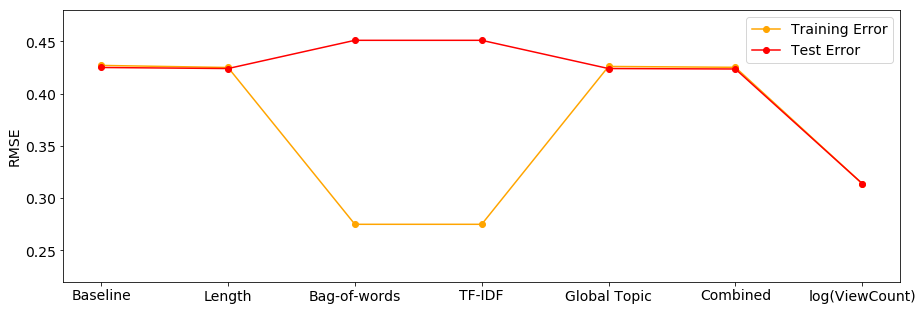

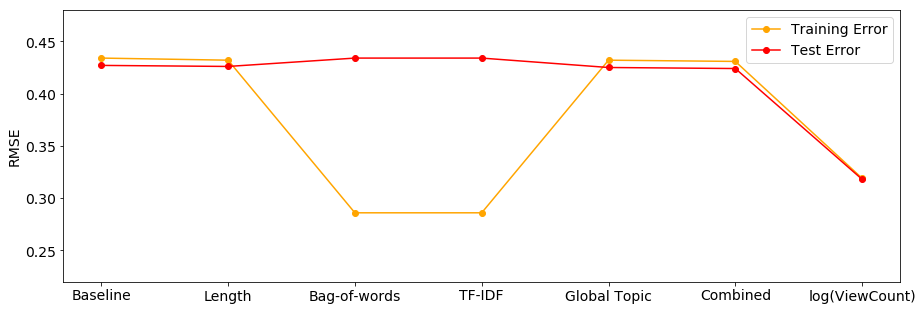

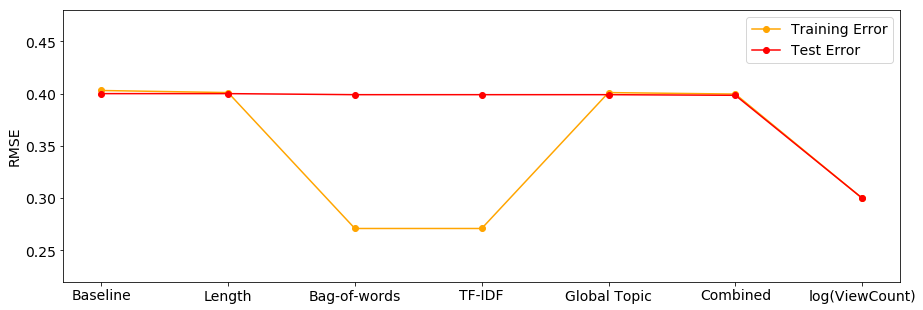

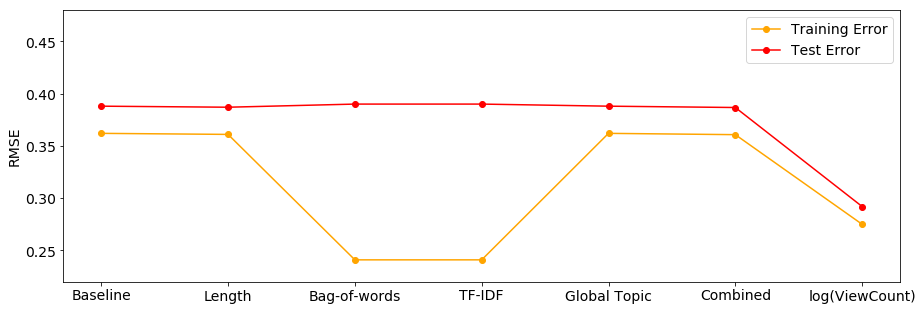

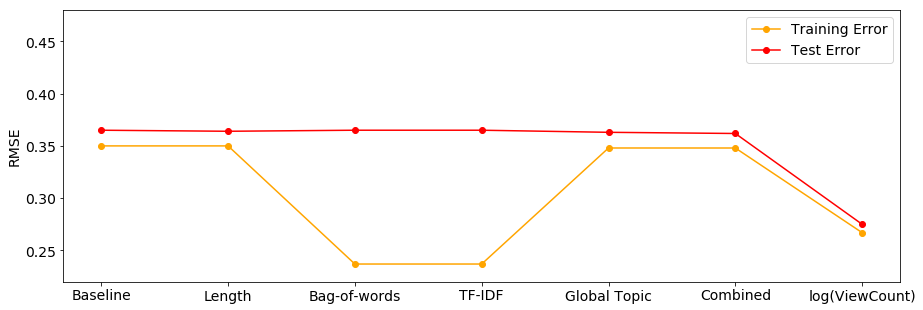

In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

# choose graph font size
font_size = 14
matplotlib.rcParams.update({'font.size': font_size})

# choose graph fig size
fig_size = (15, 5)

# load datasets
mean_res = pd.read_csv('mean_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'time'])[1:]
leng_res = pd.read_csv('leng_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'imprv', 'lambda', 'time'])[1:]
token_res = pd.read_csv('token_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'imprv', 'lambda', 'time'])[1:]
tfidf_res = pd.read_csv('tfidf_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'imprv', 'lambda', 'time'])[1:]
topic_res = pd.read_csv('topic_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'imprv', 'lambda', 'time'])[1:]
final_res = pd.read_csv('final_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'imprv', 'lambda', 'time'])[1:]
viewc_res = pd.read_csv('viewc_preds-rmse-results.csv', names=['month', 'Training Error', 'Test Error', 'diff', 'time'])[1:]

# convert train and test columns to numeric
graph_cols = ['Training Error', 'Test Error']

mean_res[graph_cols] = mean_res[graph_cols].apply(pd.to_numeric)
leng_res[graph_cols] = leng_res[graph_cols].apply(pd.to_numeric)
token_res[graph_cols] = token_res[graph_cols].apply(pd.to_numeric)
tfidf_res[graph_cols] = token_res[graph_cols].apply(pd.to_numeric)
topic_res[graph_cols] = topic_res[graph_cols].apply(pd.to_numeric)
final_res[graph_cols] = final_res[graph_cols].apply(pd.to_numeric)
viewc_res[graph_cols] = viewc_res[graph_cols].apply(pd.to_numeric)

# convert month column to categorical

mean_res['month'] = mean_res['month'].astype('category')
leng_res['month'] = leng_res['month'].astype('category')
token_res['month'] = mean_res['month'].astype('category')
tfidf_res['month'] = mean_res['month'].astype('category')
topic_res['month'] = mean_res['month'].astype('category')
final_res['month'] = mean_res['month'].astype('category')
viewc_res['month'] = mean_res['month'].astype('category')

# label models
mean_res['model'] = 'Baseline'
leng_res['model'] = 'Length'
token_res['model'] = 'Bag-of-words'
tfidf_res['model'] = 'TF-IDF'
topic_res['model'] = 'Global Topic'
final_res['model'] = 'Combined'
viewc_res['model'] = 'log(ViewCount)'

# aggregate all data sets #.append(tfidf_res)
agg_data = mean_res.append(leng_res).append(token_res).append(tfidf_res).append(topic_res).append(final_res).append(viewc_res)

# select monthly datasets
may_data = agg_data[agg_data['month'] == 'May-09']
jun_data = agg_data[agg_data['month'] == 'Jun-09']
jul_data = agg_data[agg_data['month'] == 'Jul-09']
aug_data = agg_data[agg_data['month'] == 'Aug-09']
sep_data = agg_data[agg_data['month'] == 'Sep-09']

# plot monthly datasets
k=0
for i in [may_data, jun_data, jul_data, aug_data, sep_data]:
    fig, ax = plt.subplots(figsize=fig_size)
    plt.plot( 'model', 'Training Error', data=i, color='orange', marker='o') #, order=['Constant Mean','Length','Unigram Text', 'Global Topic', 'Final', 'log(ViewCount)'])
    plt.plot( 'model', 'Test Error', data=i, color='red', marker='o')
    
    # set axes labels
    #ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    
    # set x-axis ticks to diagonal
    #plt.xticks(rotation=45)
    
    # set y-axis limits
    ax.set_ylim(0.22, 0.48)  

    # plot legend
    plt.legend()
    
    # save figure
    plt.savefig(f'01-eda/01-graphs/{data_array[k]}-rmse-results.png', bbox_inches="tight")
    
    # increment k
    k = k+1

In [ ]:
break

# Save predictions

In [ ]:
(trained_pipeline
 .transform(datasets['english'])
 .select(
    indep_text_variables + ["prediction"]
 )
 .write
 .parquet("linreg_prediction.parquet")
)

In [ ]:
linreg_predictions = spark.read.parquet("linreg_prediction.parquet")

In [ ]:
linreg_predictions.toPandas().head()

In [ ]:
linreg_predictions.select("prediction").describe().toPandas()

# Save pipelines

In [ ]:
from joblib import dump, load
dump(estimator_pipeline, 'pipeline.joblib') 

reloaded = load("pipeline.joblib")

#Now we can predict directly!

reloaded.predict(X)[:10]

In [ ]:
## save models DOESN'T WORK BECAUSE: 'NLTKWordPunctTokenizer' object has no attribute '_to_java'
for i in data_array:
    param_dict[i].save(f'{i}-pipeline') 

# Convert notebook to python file

In [ ]:
!jupyter nbconvert --to script 0-master-notebook-pipelines.ipynb